In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
newData = pd.read_csv('Office_Garman.csv',
                   index_col="timestamp",
                  parse_dates=True)
newData.head()

,Office_Garman
timestamp,
2014-12-01 00:00:00,299.3
2014-12-01 01:00:00,315.0
2014-12-01 02:00:00,311.3
2014-12-01 03:00:00,314.7
2014-12-01 04:00:00,316.0


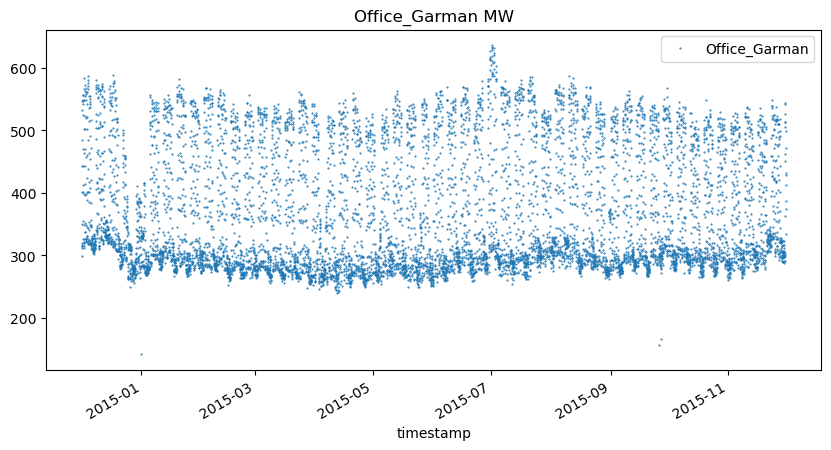

In [3]:
color_pal = sns.color_palette()
newData.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Office_Garman MW')
plt.show()

## Time Series Features

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(newData, label='Office_Garman')
features_and_target = pd.concat([X, y], axis=1)

/var/folders/p5/4n4tz9b556x0wctr33bl1jkh0000gp/T/ipykernel_39280/2283182239.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


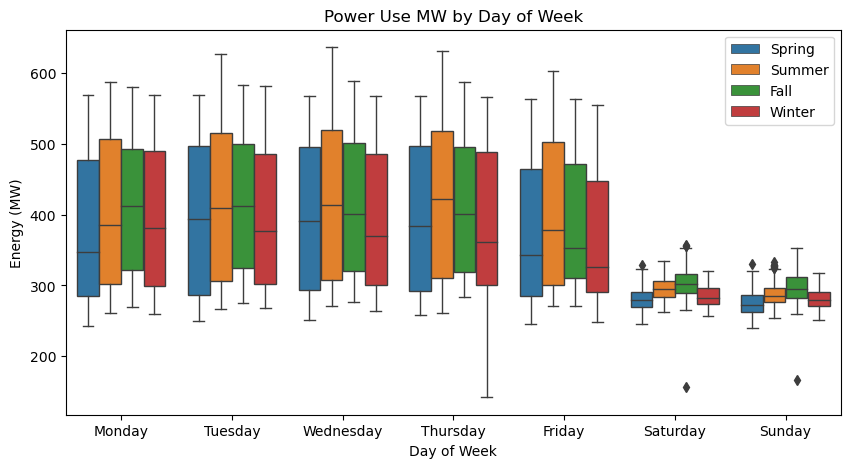

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Office_Garman',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Train / Test Split

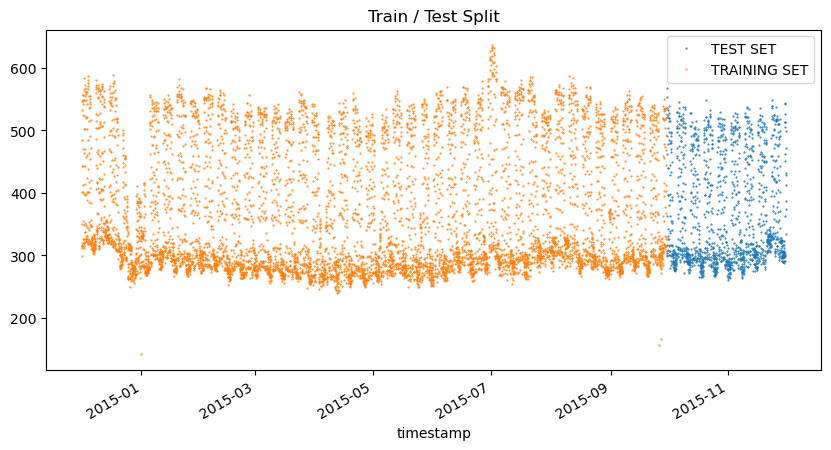

In [12]:
split_date = '30-Sep-2015'
train = newData.loc[newData.index <= split_date].copy()
test = newData.loc[newData.index > split_date].copy()

# Plot train and test so you can see where we have split
test \
    .rename(columns={'Office_Garman': 'TEST SET'}) \
    .join(train.rename(columns={'Office_Garman': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Train / Test Split', style='.', ms=1)
plt.show()

## Simple Prophet Model


In [19]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'Office_Garman':'y'})

In [20]:
%%time
model = Prophet()
model.fit(train_prophet)

18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:40 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 191 ms, sys: 28.1 ms, total: 219 ms
Wall time: 1.64 s


In [21]:
# Predict on test set with model
test_prophet = test.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'Office_Garman':'y'})

test_fcst = model.predict(test_prophet)

In [22]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-09-30 01:00:00,365.804870,258.408930,386.108714,365.804870,365.804870,-43.484350,-43.484350,-43.484350,-78.926858,-78.926858,-78.926858,35.442508,35.442508,35.442508,0.0,0.0,0.0,322.320521
1,2015-09-30 02:00:00,365.793812,258.766288,387.445605,365.793812,365.793812,-44.769239,-44.769239,-44.769239,-80.245529,-80.245529,-80.245529,35.476290,35.476290,35.476290,0.0,0.0,0.0,321.024572
2,2015-09-30 03:00:00,365.782753,261.431020,379.685236,365.782753,365.782753,-48.869866,-48.869866,-48.869866,-84.428503,-84.428503,-84.428503,35.558637,35.558637,35.558637,0.0,0.0,0.0,316.912887
3,2015-09-30 04:00:00,365.771694,252.789341,378.660415,365.771694,365.771694,-48.896007,-48.896007,-48.896007,-84.581635,-84.581635,-84.581635,35.685628,35.685628,35.685628,0.0,0.0,0.0,316.875687
4,2015-09-30 05:00:00,365.760635,270.575420,393.550197,365.760635,365.760635,-34.965403,-34.965403,-34.965403,-70.818216,-70.818216,-70.818216,35.852814,35.852814,35.852814,0.0,0.0,0.0,330.795232


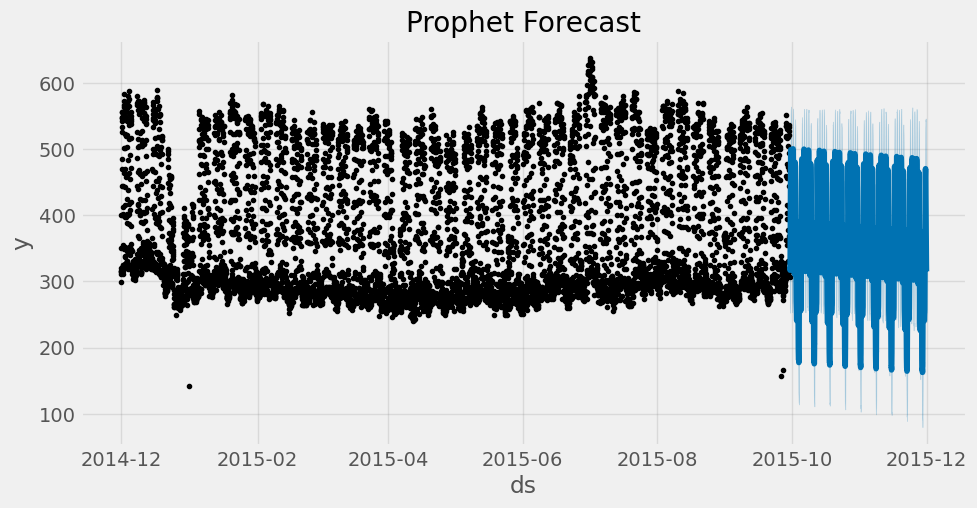

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

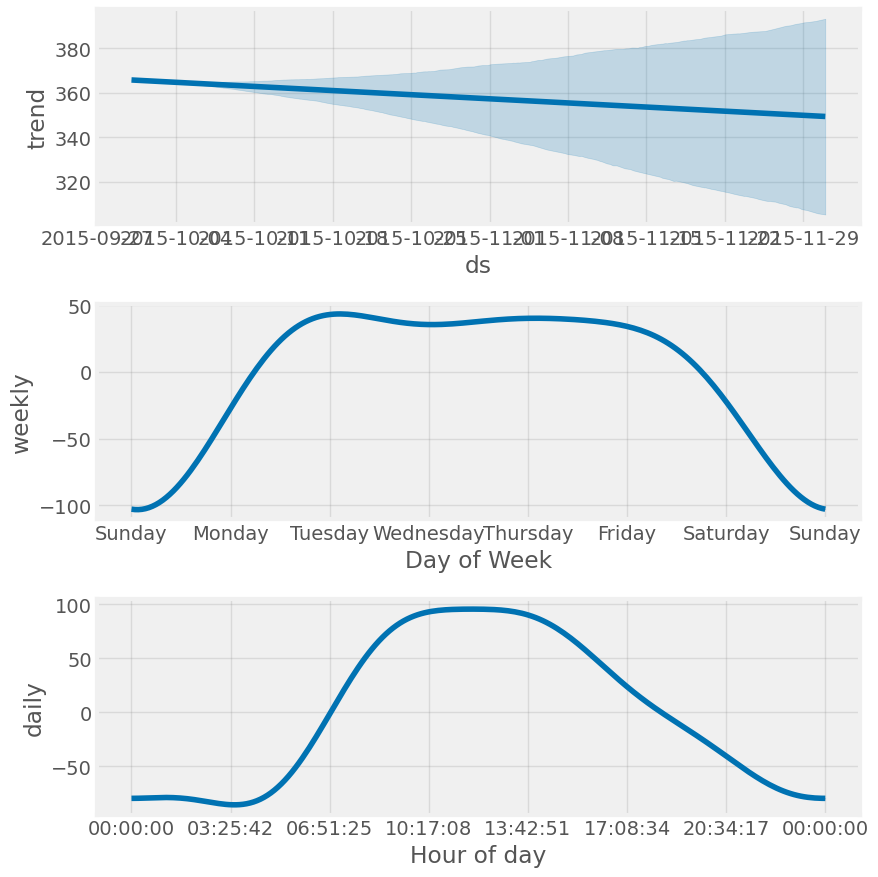

In [25]:
fig = model.plot_components(test_fcst)
plt.show()

### Compare Forecast to Actuals

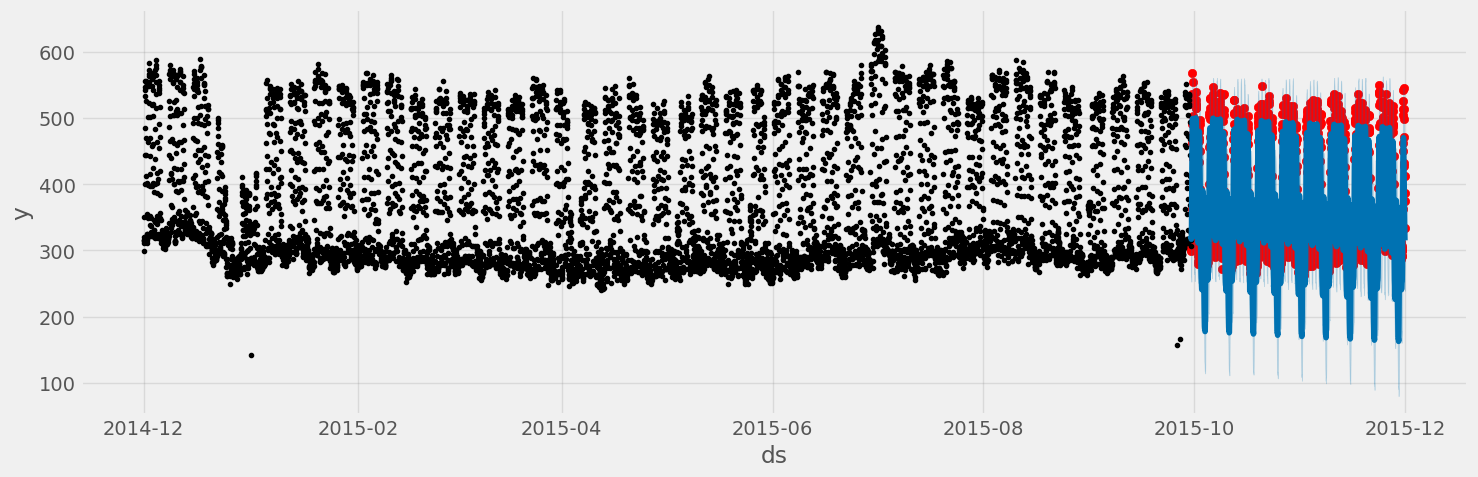

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Office_Garman'], color='r')
fig = model.plot(test_fcst, ax=ax)

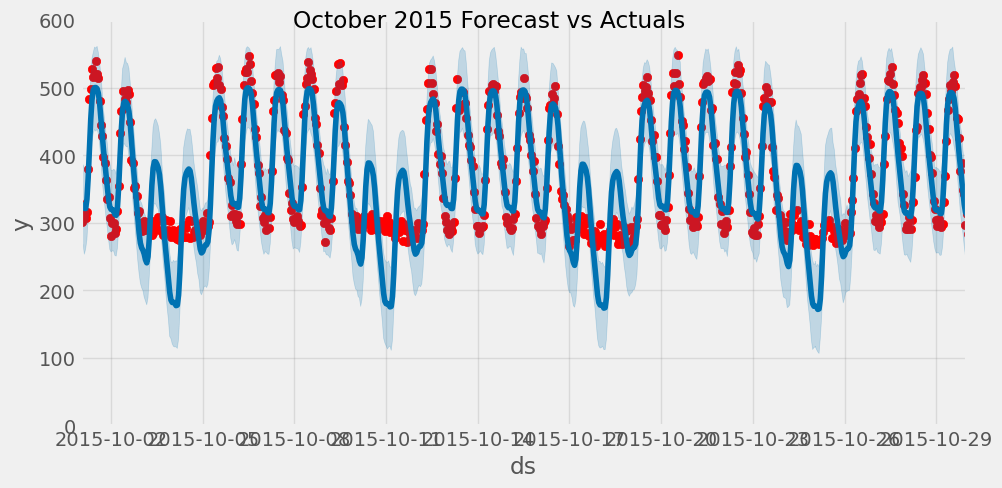

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['Office_Garman'], color='r')
fig = model.plot(test_fcst, ax=ax)
lower_bound = pd.to_datetime('2015-10-01')
upper_bound = pd.to_datetime('2015-10-30')
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 600)
plot = plt.suptitle('October 2015 Forecast vs Actuals')

plt.show()

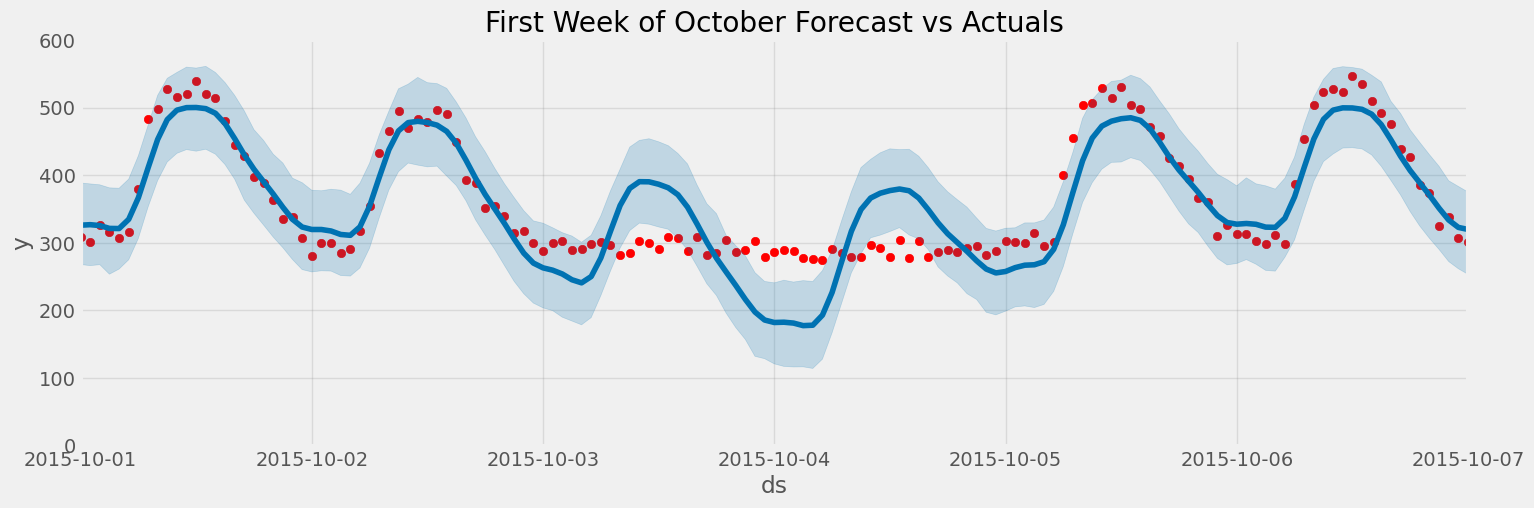

In [60]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Office_Garman'], color='r')
fig = model.plot(test_fcst, ax=ax)

lower_bound = pd.to_datetime('2015-10-01')
upper_bound = pd.to_datetime('2015-10-07')
ax.set_xbound(lower=lower_bound, upper=upper_bound)

ax.set_ylim(0, 600)
ax.set_title('First Week of October Forecast vs Actuals')
plt.show()

### Evaluate the model with Error Metrics

In [42]:
np.sqrt(mean_squared_error(y_true=test['Office_Garman'],
                   y_pred=test_fcst['yhat']))

44.42938253227169

In [43]:
mean_absolute_error(y_true=test['Office_Garman'],
                   y_pred=test_fcst['yhat'])

34.56372842337043

In [44]:
mean_absolute_percentage_error(y_true=test['Office_Garman'],
                   y_pred=test_fcst['yhat'])

10.270588238154293

## Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [103]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=newData.index.min(),
                        end=newData.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

holiday_df.head(11)

,ds,holiday
0,2014-12-25,Christmas Day
1,2015-01-01,New Year's Day
2,2015-01-19,"Birthday of Martin Luther King, Jr."
3,2015-02-16,Washington’s Birthday
4,2015-05-25,Memorial Day
5,2015-07-03,Independence Day
6,2015-09-07,Labor Day
7,2015-10-12,Columbus Day
8,2015-11-11,Veterans Day
9,2015-11-26,Thanksgiving Day


In [84]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train_prophet)


19:12:47 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 248 ms, sys: 31.4 ms, total: 279 ms
Wall time: 1.72 s


In [73]:
# Predict on training set with model
test_fcst_with_hols = \
    model_with_holidays.predict(df=test_prophet)

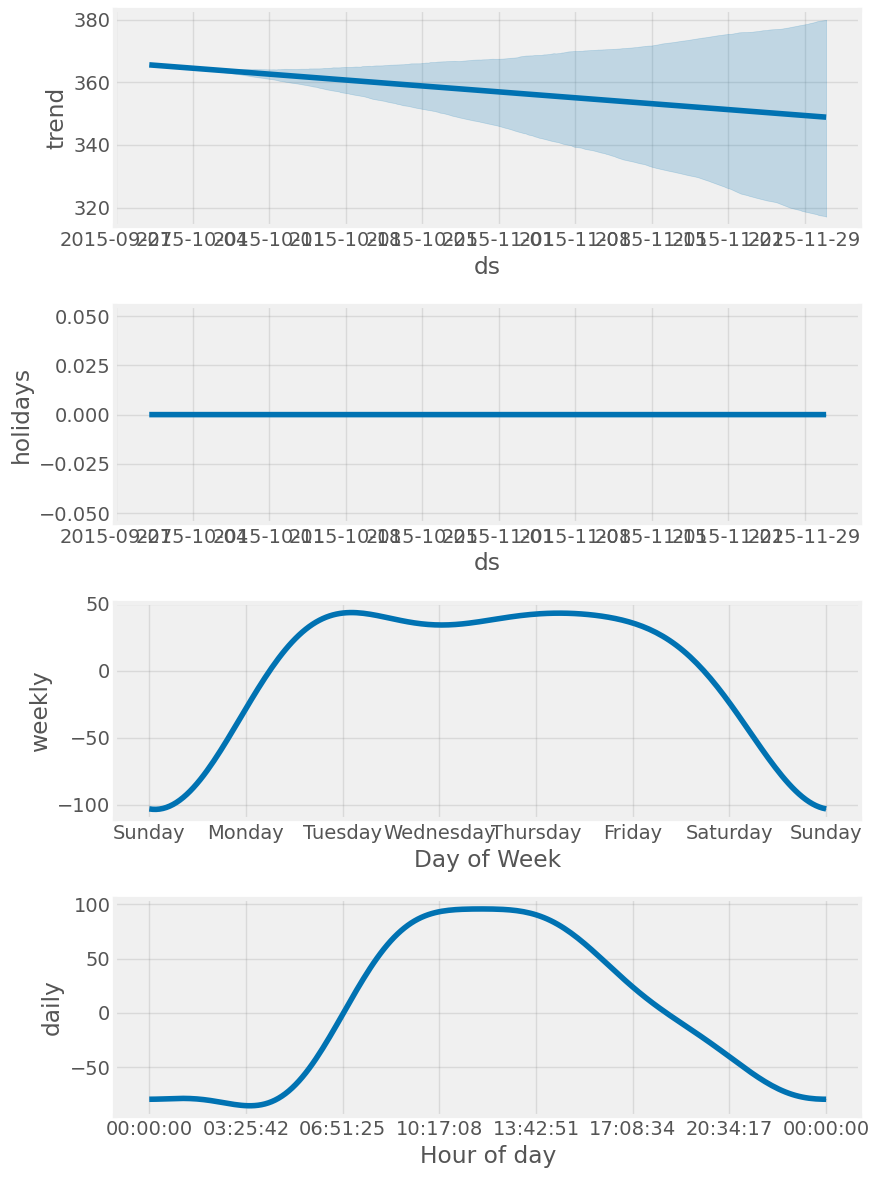

In [74]:
fig = model_with_holidays.plot_components(
    test_fcst_with_hols)
plt.show()

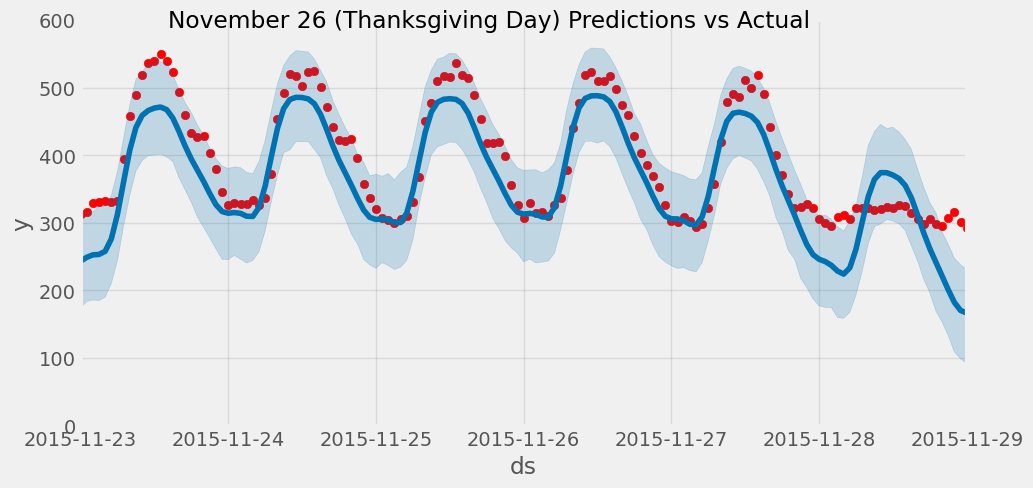

In [90]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['Office_Garman'], color='r')
fig = model.plot(test_fcst_with_hols, ax=ax)

lower_bound = pd.to_datetime('2015-11-23')
upper_bound = pd.to_datetime('2015-11-29')
ax.set_xbound(lower=lower_bound, upper=upper_bound)

ax.set_ylim(0, 600)
plot = plt.suptitle('November 26 (Thanksgiving Day) Predictions vs Actual')

In [100]:
# Access the holiday components of the forecast
holiday_components = test_fcst_with_hols['holidays']

# Check if holidays are accounted for
if (holiday_components != 0).any():
    print("Holidays are accounted for in the predictions.")
else:
    print("Holidays are not accounted for in the predictions.")


Holidays are not accounted for in the predictions.
